# 估计

## 把上一章做的Suite拿过来

In [1]:
from code.thinkbayes import Pmf
from abc import ABCMeta, abstractmethod
class Suite(Pmf): # 抽象类
    
    __metaclass__ = ABCMeta
    
    def __init__(self, hypos):
        '''
        构造函数
        
        Args:
            hypos -- 全部假设
        '''
        Pmf.__init__(self)
        for hypo in hypos:
            self.Set(hypo, 1)
        self.Normalize()
    
    @abstractmethod  ##抽象方法
    def Likelihood(self, data, hypo):
        '''
        根据传入data求似然度
        
        Args:
            data -- 传入的信息
            hypo -- 某一种假设
            
        Returns:
            like -- 更新后的概率
        '''
        
    def Update(self, data):
        '''
        修正相应假设的概率，这个方法是叠加的
        
        Args:
            data -- 用于修正响应假设概率的信息
        '''
        for hypo in self.Values():
            like = self.Likelihood(data, hypo)
            self.Mult(hypo, like)
        self.Normalize()
        
    def PrintPredict(self):
        '''
        打印各个假设及其对应的概率
        '''
        for hypo, prob in self.Items():
            print hypo + ':' + str(prob)
        

## 骰子问题 -- Suite解决

箱子中有4面、6面、8面、12面、20面骰子各一个，问题随机取其中一个，转动得到了6，那么各个骰子被取到的概率是多少？

分析：
1. 针对问题，有5个假设，分别是取到4面骰子、6面骰子、8面骰子、12面骰子、20面骰子；
2. 初始概率均等1/6；
3. 每个骰子各自点数的概率为1/面数；
4. 信息是骰子转动得到6；

In [19]:
class Dice(Suite):
    
    dc = {
        'A':dict(a=1/4.,b=1/4.,c=1/4.,d=1/4.),
        'B':dict(a=1/6.,b=1/6.,c=1/6.,d=1/6.,
               e=1/6.,f=1/6.),
        'C':dict(a=1/8.,b=1/8.,c=1/8.,d=1/8.,
               e=1/8.,f=1/8.,g=1/8.,h=1/8.),
        'D':dict(a=1/12.,b=1/12.,c=1/12.,d=1/12.,
               e=1/12.,f=1/12.,g=1/12.,h=1/12.,
               i=1/12.,j=1/12.,k=1/12.,l=1/12.),
        'E':dict(a=1/20.,b=1/20.,c=1/20.,d=1/20.,
               e=1/20.,f=1/20.,g=1/20.,h=1/20.,
               i=1/20.,j=1/20.,k=1/20.,l=1/20.,
               m=1/20.,n=1/20.,o=1/20.,p=1/20.,
               q=1/20.,r=1/20.,s=1/20.,t=1/20.),
    }
    
    def Likelihood(self, data, hypo):
        data = chr(int(data)-1+ord('a'))
        return self.dc[hypo][data] if self.dc[hypo].has_key(data) else 0
    
dice = Dice('ABCDE') # 分别对应4、6、8、12、20
dice.Update(6)
dice.PrintPredict()

A:0.0
C:0.294117647059
B:0.392156862745
E:0.117647058824
D:0.196078431373


In [20]:
for roll in [6, 8, 7, 7, 5, 4]:
    dice.Update(roll)
dice.PrintPredict()

A:0.0
C:0.943248453672
B:0.0
E:0.0015454182665
D:0.0552061280613


## 火车头问题 -- Suite解决

铁路上以1到N命名火车头，有一天你看到一个标号为60的火车头，请估计铁路上有多少火车头？

分析：
1. 已知有N个火车头；
2. 看到标号为60，那我们就理解为至少有60个火车头；
3. 信息不多，可能需要很多假设来计算概率；

### 假设有1~1000的可能性

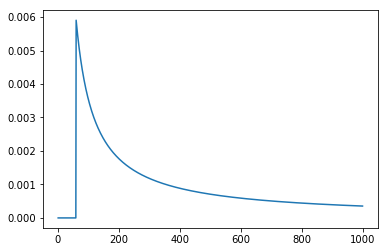

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
class Train(Suite):
    def Likelihood(self, data, hypo):
        return 0 if data>hypo else 1./hypo
    
    def PrintPredict(self):
        hypos, prods = [],[]
        for hypo, prod in self.Items():
            hypos.append(hypo)
            prods.append(prod)
        plt.plot(hypos, prods)
        
    def PosteriorProbabilityMean(self):
        total = 0
        for hypo, prod in self.Items():
            total += hypo*prod
        return total
    
hypos = range(1,1001)
train = Train(hypos)
train.Update(60)
train.PrintPredict()

小结：在目前信息下，直观计算最大概率就是总数为60时；

### 使用后验概率平均值分布

In [26]:
print train.PosteriorProbabilityMean()

333.419893264


小结：此处的333代表所有假设值（1~1000）乘以自身对应的概率时之和，因为是归一化的，也就是说所有假设概率之和为1，因此这个值就相当于每个假设乘以自身的权重得到的值，比如1:0.5,2:0.3,3:0.2，那么该值就是1\*0.5+2\*0.3+3\*0.2=1.7，这个1.7就是这一组数据的后验概率平均值；

### 计算其他假设情况下的后验概率平均值分布

#### 最多100辆火车头

In [28]:
train = Train(range(1,101))
train.Update(60)
print train.PosteriorProbabilityMean()

78.2183356753


#### 最多500辆火车头

In [27]:
train = Train(range(1,501))
train.Update(60)
print train.PosteriorProbabilityMean()

207.079227983


#### 最多2000辆火车头

In [29]:
train = Train(range(1,2001))
train.Update(60)
print train.PosteriorProbabilityMean()

552.179017165


#### 假设至多数量的影响

小结：能看到这个后验概率平均值对至多假设非常敏感，这个可信度就不高了；

## 解决后验概率平均值对至多假设敏感

一般有两种方式：
1. 获取更多信息，比如看到了其他标号的火车头；
2. 更多的背景信息，比如知晓了本地运营公司的火车数量分布；

### 假设看到了其他标号的火车头，比如看到了60,30,40

#### 假设至多100

In [30]:
train = Train(range(1,101))
for number in [30, 40, 60]:
    train.Update(number)
train.PosteriorProbabilityMean()

74.7505851251708

#### 假设至多500

In [31]:
train = Train(range(1,501))
for number in [30, 40, 60]:
    train.Update(number)
train.PosteriorProbabilityMean()

106.36102951451466

#### 假设至多1000

In [32]:
train = Train(range(1,1001))
for number in [30, 40, 60]:
    train.Update(number)
train.PosteriorProbabilityMean()

112.32543159449729

#### 结论

小结：能够看到，在丰富了信息后，明显出现后验概率平均值更加稳定的情况，那么这个值也就更加可信；

### 获取更多的背景信息

已知公司规模的分布往往遵循幂律，也就是说如果拥有少于10个火车头的公司有1000家，那么少于100个就有100家，1000个的就有10家，而10000的可能仅有1家，因此我们考虑使用幂律来优化我们的先验概率（之前是均等的先验概率），幂律表示公司规模与公司数量成反比，或者如下：

$$PMF(x)\propto\lgroup\frac{1}{x}\rgroup^\alpha$$

其中PMF(x)是x的概率质量函数，$\alpha$是一个通常接近1的参数；

In [35]:
class TrainPlus(Train):
    def __init__(self, hypos, alpha=1.):
        Pmf.__init__(self)
        for hypo in hypos:
            self.Set(hypo, hypo ** -alpha)
        self.Normalize()

#### 假设至多100

In [36]:
train = TrainPlus(range(1,101))
for number in [30, 40, 60]:
    train.Update(number)
train.PosteriorProbabilityMean()

73.15096767791759

#### 假设至多500

In [37]:
train = TrainPlus(range(1,501))
for number in [30, 40, 60]:
    train.Update(number)
train.PosteriorProbabilityMean()

88.14288985789013

#### 假设至多1000

In [38]:
train = TrainPlus(range(1,1001))
for number in [30, 40, 60]:
    train.Update(number)
train.PosteriorProbabilityMean()

88.9593186332632

#### 假设至多2000

In [39]:
train = TrainPlus(range(1,2001))
for number in [30, 40, 60]:
    train.Update(number)
train.PosteriorProbabilityMean()

89.17968456944745

#### 假设至多10000

In [40]:
train = TrainPlus(range(1,10001))
for number in [30, 40, 60]:
    train.Update(number)
train.PosteriorProbabilityMean()

89.25316033198662

#### 优化先验概率总结

小结：能够看到在根据幂律优化先验概率后，后验概率平均值更加稳定，基本收敛到89，因此可以说基于幂律的先验概率是更加现实的，同时也表现更好，也符合实际公司规模/数量分布规律；

## 置信区间

计算出后验分布后，通过点估计或区间对后验分布进行总结通常是很有必要的；
1. 点估计：通常是平均数、中位数或最大似然值；
2. 区间则是给出两个值，使得未知量有90%落入该范围中；

### 计算区间5%~95%

In [43]:
def Percentile(pmf, percentage):#求分位数
    total = 0
    for hypo, prob in pmf.Items():
        total += prob
        if total >= percentage/100.:
            return hypo
        
print Percentile(train, 5), Percentile(train, 95)

61 162


小结：看到，即便是经过增加信息，以及背景调查的先验概率优化，在90%范围内依然有很大的空间，这表示我们对结果依然是存疑的；

## 累积分布函数

## 德军坦克问题

## 讨论

在贝叶斯当中，有两种选择先验概率的方式：
1. 选择最能代表问题相关背景资料的先验概率（比如火车头问题中符合幂律的公司规模和数量），此种情况下，先验被认为是”信息“，问题是，不同的人分析该问题可能会使用不同的背景信息（或者说进行不同的解释），所以这种先验的方式显得比较主观；
2. 另一种是所谓的”无信息参考的先验“，比如最初的火车头问题，我们就是假设每种可能的概率一致，其目的是为了让后续的数据来决定，而不是由分析人的主观来决定，在某些情况下，你可以选择包含一些期望属性的特殊先验，例如，就估计量设置一个最小先验；

比较：”无信息参考先验“的存在是因为它们似乎更为客观，但是通常，我们倾向于选择使用先验信息，这是因为贝叶斯分析总是基于模型决策的。而选择先验就是决策之一，但它不是唯一的部分，甚至不是最主观的部分，因此，即使”无信息参考先验“更加客观，但是整个分析依然是主观的。另外，对于实际问题，你很可能处于两种情况下：1.有大量数据，2.没有什么数据，对于1，是否使用先验信息都无所谓，因为大量数据会将结果导向同一个数值，而对于2，例如火车头问题，此时如果不参考有效的背景信息优化先验，那么得到的结果几乎是没有任何意义的，因此我们应该充分利用所有信息，而不是固执的认为需要保持完全的客观就是好的；

## 练习